# Deep Lens Detection

This notebook demonstrates a deep learning approach for identifying strong gravitational lenses in astronomical images. We use a Convolutional Neural Network (CNN) implemented in PyTorch. The dataset comprises images in three filters stored as `.npy` files with shape `(3, 64, 64)`.

**Key Objectives:**
- Load and explore the dataset.
- Preprocess data and handle class imbalance.
- Train a CNN with early stopping.
- Evaluate the model using ROC curves, AUC score, and confusion matrices.
- Visualize model performance and misclassified examples.

In [1]:
# Importing necessary libraries
import os
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset, DataLoader, random_split
from sklearn.model_selection import train_test_split
from collections import Counter
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from sklearn.metrics import roc_auc_score, roc_curve, auc, confusion_matrix, ConfusionMatrixDisplay
from tqdm import tqdm
import random

## Dataset Overview

The dataset contains observational data of strong lenses and non-lensed galaxies. The images are divided into four directories:
- **Train Data:**
  - `train_lenses`: Images of lensed galaxies.
  - `train_nonlenses`: Images of non-lensed galaxies.
- **Test Data:**
  - `test_lenses`: Test images of lensed galaxies.
  - `test_nonlenses`: Test images of non-lensed galaxies.

Each image is stored as a NumPy array (`.npy`) with shape `(3, 64, 64)`, corresponding to three different filters.

In [2]:
base_path = '/kaggle/input/deeplensetask2'
train_lenses_path = os.path.join(base_path, 'train_lenses')
train_nonlenses_path = os.path.join(base_path, 'train_nonlenses')

In [3]:
dirs = {
    'train_lenses': os.path.join(base_path, 'train_lenses'),
    'train_nonlenses': os.path.join(base_path, 'train_nonlenses'),
    'test_lenses': os.path.join(base_path, 'test_lenses'),
    'test_nonlenses': os.path.join(base_path, 'test_nonlenses')
}

## Exploratory Data Analysis (EDA)

- List the files in each directory.
- Load and visualize sample images from the dataset.
- Analyze the distribution of classes in the training data.


Sample image shape: (3, 64, 64)


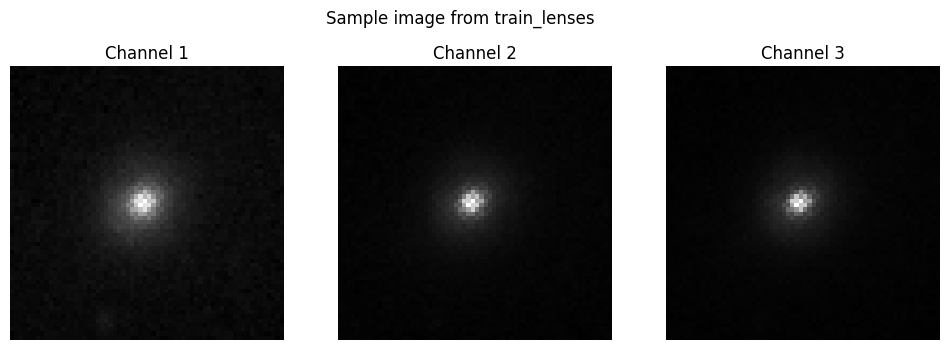

In [4]:
train_lenses_files = os.listdir(dirs['train_lenses'])
sample_file = os.path.join(dirs['train_lenses'], train_lenses_files[0])

sample_image = np.load(sample_file)
    

print(f"\nSample image shape: {sample_image.shape}")
    
# Plotting the three channels as subplots
fig, axes = plt.subplots(1, 3, figsize=(12, 4))
for i in range(3):
    axes[i].imshow(sample_image[i], cmap='gray')
    axes[i].set_title(f'Channel {i+1}')
    axes[i].axis('off')
plt.suptitle('Sample image from train_lenses')
plt.show()

In [5]:
def get_file_paths(directory):
    return [os.path.join(directory, f) for f in os.listdir(directory) if f.endswith('.npy')]

lens_files = get_file_paths(train_lenses_path)
nonlens_files = get_file_paths(train_nonlenses_path)

In [6]:
file_paths = lens_files + nonlens_files
labels = [1] * len(lens_files) + [0] * len(nonlens_files)
print("Overall label distribution:", Counter(labels))

Overall label distribution: Counter({0: 28675, 1: 1730})


In [7]:
train_files, val_files, train_labels, val_labels = train_test_split(
    file_paths, labels, test_size=0.1, stratify=labels, random_state=42
)

print(f"\nTraining set size: {len(train_files)}")
print(f"Validation set size: {len(val_files)}")
print("Training label distribution:", Counter(train_labels))
print("Validation label distribution:", Counter(val_labels))


Training set size: 27364
Validation set size: 3041
Training label distribution: Counter({0: 25807, 1: 1557})
Validation label distribution: Counter({0: 2868, 1: 173})


In [8]:
class LensDataset(Dataset):
    def __init__(self, file_list, labels, transform=None):
        self.file_list = file_list
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, idx):
        
        image = np.load(self.file_list[idx])
        
        image = image.astype(np.float32)
        
        image = torch.tensor(image)
        label = torch.tensor(self.labels[idx], dtype=torch.long)
        
        if self.transform:
            image = self.transform(image)
        return image, label

## Data Preprocessing & Train-Validation Split

We preprocess the data by:
- Loading the `.npy` files.
- Creating a custom PyTorch Dataset.
- Splitting the data into training (90%) and validation (10%) sets.
- Addressing class imbalance using class weights.

In [9]:
train_dataset = LensDataset(train_files, train_labels)
val_dataset = LensDataset(val_files, val_labels)

In [10]:
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

sample_img, sample_label = train_dataset[0]
print(f"\nSample image tensor shape: {sample_img.shape}")
print(f"Sample label: {sample_label}")


Sample image tensor shape: torch.Size([3, 64, 64])
Sample label: 0


## Model Architecture & Training Setup

The model, **LensNet**, is a CNN with:
- Three convolutional layers and ReLU activations.
- Max pooling layers to reduce dimensionality.
- Dropout to prevent overfitting.
- Fully connected layers for classification.

early stopping is used to halt training if the validation loss does not improve after a certain number of epochs. 

In [11]:
class LensNet(nn.Module):
    def __init__(self):
        super(LensNet, self).__init__()
        
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, padding=1)
        
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        
        self.pool = nn.MaxPool2d(2, 2)
        
        self.dropout = nn.Dropout(0.5)
        
        self.fc1 = nn.Linear(64 * 8 * 8, 128)
        self.fc2 = nn.Linear(128, 2)  

    def forward(self, x):
        
        x = F.relu(self.conv1(x))   
        x = self.pool(x)            
        x = F.relu(self.conv2(x))   
        x = self.pool(x)            
        x = F.relu(self.conv3(x))   
        x = self.pool(x)           
        x = x.view(-1, 64 * 8 * 8)   
        x = self.dropout(x)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)             
        return x


In [12]:
model = LensNet()
print("Model architecture:\n", model)

Model architecture:
 LensNet(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc1): Linear(in_features=4096, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=2, bias=True)
)


In [13]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

In [14]:
total_samples = len(train_labels)
num_classes = 2
count_nonlens = 25807
count_lens = 1557
weight_nonlens = total_samples / (num_classes * count_nonlens)
weight_lens = total_samples / (num_classes * count_lens)
class_weights = torch.tensor([weight_nonlens, weight_lens], dtype=torch.float).to(device)
print(f"\nCalculated class weights: {class_weights.cpu().numpy()}")


Calculated class weights: [0.5301662 8.787412 ]


In [15]:
criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [16]:
patience = 3  
best_val_loss = float('inf')
early_stop_counter = 0

In [17]:
best_model_path = '/kaggle/working/best_model.pth'

In [18]:
num_epochs = 50
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    train_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} Training", leave=False)
    
    for images, labels in train_bar:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * images.size(0)
        train_bar.set_postfix(loss=loss.item())
    
    epoch_loss = running_loss / len(train_dataset)
    
    
    model.eval()
    val_running_loss = 0.0
    all_labels = []
    all_preds = []
    
    with torch.no_grad():
        val_bar = tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} Validation", leave=False)
        for images, labels in val_bar:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_running_loss += loss.item() * images.size(0)
            
            probs = torch.softmax(outputs, dim=1)[:, 1]
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(probs.cpu().numpy())
            
            val_bar.set_postfix(loss=loss.item())
    
    val_loss = val_running_loss / len(val_dataset)
    try:
        val_auc = roc_auc_score(all_labels, all_preds)
    except ValueError:
        val_auc = 0.0
    
    print(f"Epoch [{epoch+1}/{num_epochs}] - Training Loss: {epoch_loss:.4f}, Validation Loss: {val_loss:.4f}, Validation AUC: {val_auc:.4f}")
    
   
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        early_stop_counter = 0
        
        torch.save(model.state_dict(), best_model_path)
        print(f"Epoch {epoch+1}: New best model saved with validation loss: {best_val_loss:.4f}")
    else:
        early_stop_counter += 1
        print(f"Epoch {epoch+1}: Early stopping counter: {early_stop_counter} / {patience}")
        if early_stop_counter >= patience:
            print(f"Early stopping triggered! Counter reached {early_stop_counter} out of {patience}.")
            break


model.load_state_dict(torch.load(best_model_path))
print("Training complete. Best validation loss: {:.4f}".format(best_val_loss))
print("Best model saved at:", best_model_path)

Epoch [1/50] - Training Loss: 0.4866, Validation Loss: 0.3701, Validation AUC: 0.9456
Epoch 1: New best model saved with validation loss: 0.3701


Epoch [2/50] - Training Loss: 0.3865, Validation Loss: 0.3048, Validation AUC: 0.9588
Epoch 2: New best model saved with validation loss: 0.3048


Epoch [3/50] - Training Loss: 0.3453, Validation Loss: 0.2595, Validation AUC: 0.9583
Epoch 3: New best model saved with validation loss: 0.2595


Epoch [4/50] - Training Loss: 0.3145, Validation Loss: 0.2471, Validation AUC: 0.9647
Epoch 4: New best model saved with validation loss: 0.2471


Epoch [5/50] - Training Loss: 0.3050, Validation Loss: 0.2316, Validation AUC: 0.9655
Epoch 5: New best model saved with validation loss: 0.2316


Epoch [6/50] - Training Loss: 0.2826, Validation Loss: 0.2303, Validation AUC: 0.9660
Epoch 6: New best model saved with validation loss: 0.2303


Epoch [7/50] - Training Loss: 0.2778, Validation Loss: 0.2256, Validation AUC: 0.9689
Epoch 7: New best model saved with validation loss: 0.2256


Epoch [8/50] - Training Loss: 0.2688, Validation Loss: 0.2472, Validation AUC: 0.9678
Epoch 8: Early stopping counter: 1 / 3


Epoch [9/50] - Training Loss: 0.2509, Validation Loss: 0.2356, Validation AUC: 0.9687
Epoch 9: Early stopping counter: 2 / 3


Epoch [10/50] - Training Loss: 0.2591, Validation Loss: 0.2221, Validation AUC: 0.9688
Epoch 10: New best model saved with validation loss: 0.2221


Epoch [11/50] - Training Loss: 0.2436, Validation Loss: 0.2061, Validation AUC: 0.9723
Epoch 11: New best model saved with validation loss: 0.2061


Epoch [12/50] - Training Loss: 0.2393, Validation Loss: 0.2009, Validation AUC: 0.9740
Epoch 12: New best model saved with validation loss: 0.2009


Epoch [13/50] - Training Loss: 0.2383, Validation Loss: 0.2368, Validation AUC: 0.9704
Epoch 13: Early stopping counter: 1 / 3


Epoch [14/50] - Training Loss: 0.2222, Validation Loss: 0.2132, Validation AUC: 0.9729
Epoch 14: Early stopping counter: 2 / 3


Epoch [15/50] - Training Loss: 0.2225, Validation Loss: 0.1980, Validation AUC: 0.9743
Epoch 15: New best model saved with validation loss: 0.1980


Epoch [16/50] - Training Loss: 0.2077, Validation Loss: 0.1881, Validation AUC: 0.9768
Epoch 16: New best model saved with validation loss: 0.1881


Epoch [17/50] - Training Loss: 0.2077, Validation Loss: 0.1871, Validation AUC: 0.9773
Epoch 17: New best model saved with validation loss: 0.1871


Epoch [18/50] - Training Loss: 0.1994, Validation Loss: 0.1816, Validation AUC: 0.9789
Epoch 18: New best model saved with validation loss: 0.1816


Epoch [19/50] - Training Loss: 0.1901, Validation Loss: 0.1763, Validation AUC: 0.9789
Epoch 19: New best model saved with validation loss: 0.1763


Epoch [20/50] - Training Loss: 0.1901, Validation Loss: 0.1946, Validation AUC: 0.9773
Epoch 20: Early stopping counter: 1 / 3


Epoch [21/50] - Training Loss: 0.1799, Validation Loss: 0.1553, Validation AUC: 0.9836
Epoch 21: New best model saved with validation loss: 0.1553


Epoch [22/50] - Training Loss: 0.1814, Validation Loss: 0.1904, Validation AUC: 0.9792
Epoch 22: Early stopping counter: 1 / 3


Epoch [23/50] - Training Loss: 0.1786, Validation Loss: 0.1936, Validation AUC: 0.9753
Epoch 23: Early stopping counter: 2 / 3


Epoch [24/50] - Training Loss: 0.1919, Validation Loss: 0.1824, Validation AUC: 0.9796
Epoch 24: Early stopping counter: 3 / 3
Early stopping triggered! Counter reached 3 out of 3.
Training complete. Best validation loss: 0.1553
Best model saved at: /kaggle/working/best_model.pth


<ipython-input-18-96fbe02882c2>:63: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(best_model_path))


In [19]:
def evaluate_model(model, data_loader, device):
    model.eval()
    all_labels = []
    all_preds = []
    with torch.no_grad():
        for images, labels in data_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            probs = torch.softmax(outputs, dim=1)[:, 1]  
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(probs.cpu().numpy())
    return all_labels, all_preds

In [20]:
val_labels, val_probs = evaluate_model(model, val_loader, device)

In [21]:
fpr, tpr, thresholds = roc_curve(val_labels, val_probs)
roc_auc = auc(fpr, tpr)

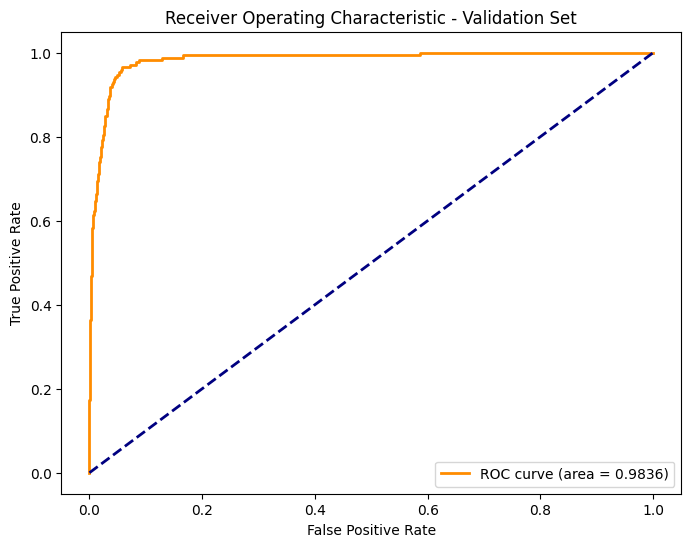

In [22]:
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic - Validation Set')
plt.legend(loc="lower right")
plt.show()

In [23]:
val_preds_class = [1 if prob >= 0.5 else 0 for prob in val_probs]

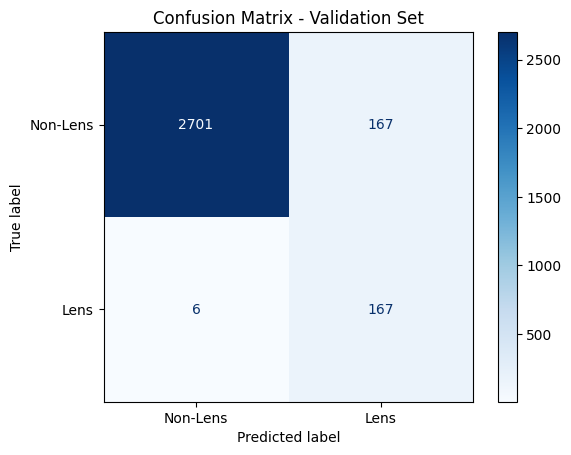

Validation AUC: 0.9836


In [24]:
cm = confusion_matrix(val_labels, val_preds_class)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Non-Lens', 'Lens'])
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix - Validation Set')
plt.show()

print(f"Validation AUC: {roc_auc:.4f}")

In [34]:
test_dirs = {
    'lens': os.path.join(base_path, 'test_lenses'),
    'nonlens': os.path.join(base_path, 'test_nonlenses')
}

In [35]:
def get_test_data(directory, label):
    files = [os.path.join(directory, f) for f in os.listdir(directory) if f.endswith('.npy')]
    labels = [label] * len(files)
    return files, labels

In [36]:
test_lens_files, lens_labels = get_test_data(test_dirs['lens'], 1)
test_nonlens_files, nonlens_labels = get_test_data(test_dirs['nonlens'], 0)

In [37]:
test_files = test_lens_files + test_nonlens_files
true_labels = lens_labels + nonlens_labels

## Evaluation Metrics & Visualization

After training, we evaluate our model on both the validation and test sets using:
- ROC curves and AUC scores.
- Confusion matrices to understand misclassification.
- Visualization of misclassified examples to identify potential improvements.

In [38]:
model.eval()
predicted_probs = []

In [39]:
with torch.no_grad():
    for file_path in test_files:
        
        image = np.load(file_path).astype(np.float32)
        image_tensor = torch.tensor(image).unsqueeze(0).to(device)
        output = model(image_tensor)
        prob = torch.softmax(output, dim=1)[0, 1].item() 
        predicted_probs.append(prob)


fpr, tpr, thresholds = roc_curve(true_labels, predicted_probs)
test_auc = auc(fpr, tpr)

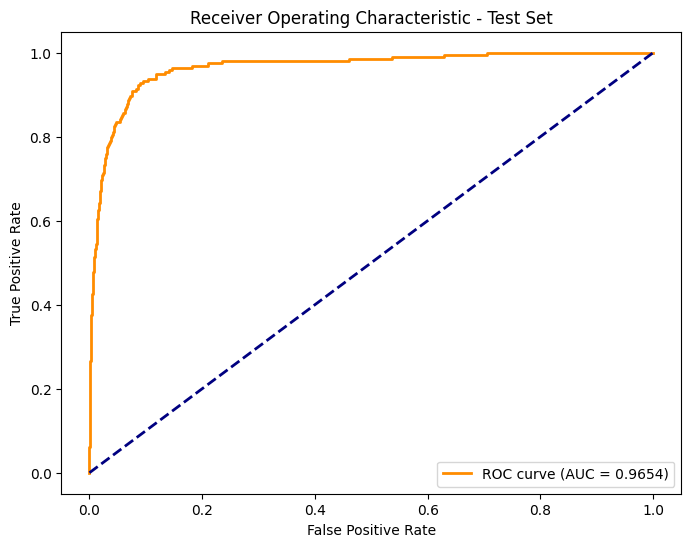

In [40]:
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {test_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic - Test Set')
plt.legend(loc="lower right")
plt.show()

In [41]:
predicted_classes = [1 if prob >= 0.5 else 0 for prob in predicted_probs]

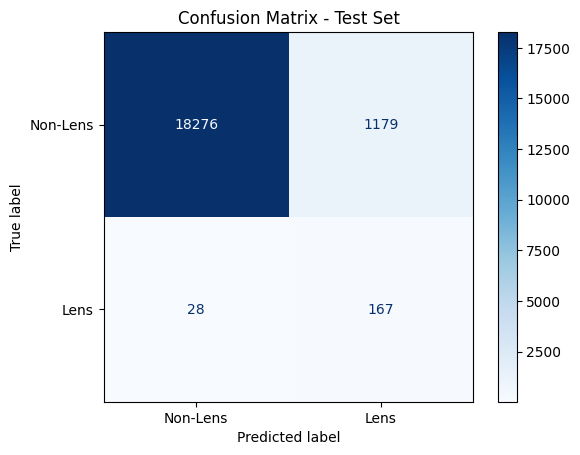

Test AUC: 0.9654


In [42]:
cm = confusion_matrix(true_labels, predicted_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Non-Lens', 'Lens'])
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix - Test Set')
plt.show()

print(f"Test AUC: {test_auc:.4f}")

In [43]:
misclassified_idx = [i for i in range(len(true_labels)) if true_labels[i] != (1 if predicted_probs[i] >= 0.5 else 0)]
print("Number of misclassified examples:", len(misclassified_idx))

Number of misclassified examples: 1207


In [44]:
num_examples = min(9, len(misclassified_idx))
if num_examples > 0:
    selected_indices = random.sample(misclassified_idx, num_examples)
else:
    selected_indices = []

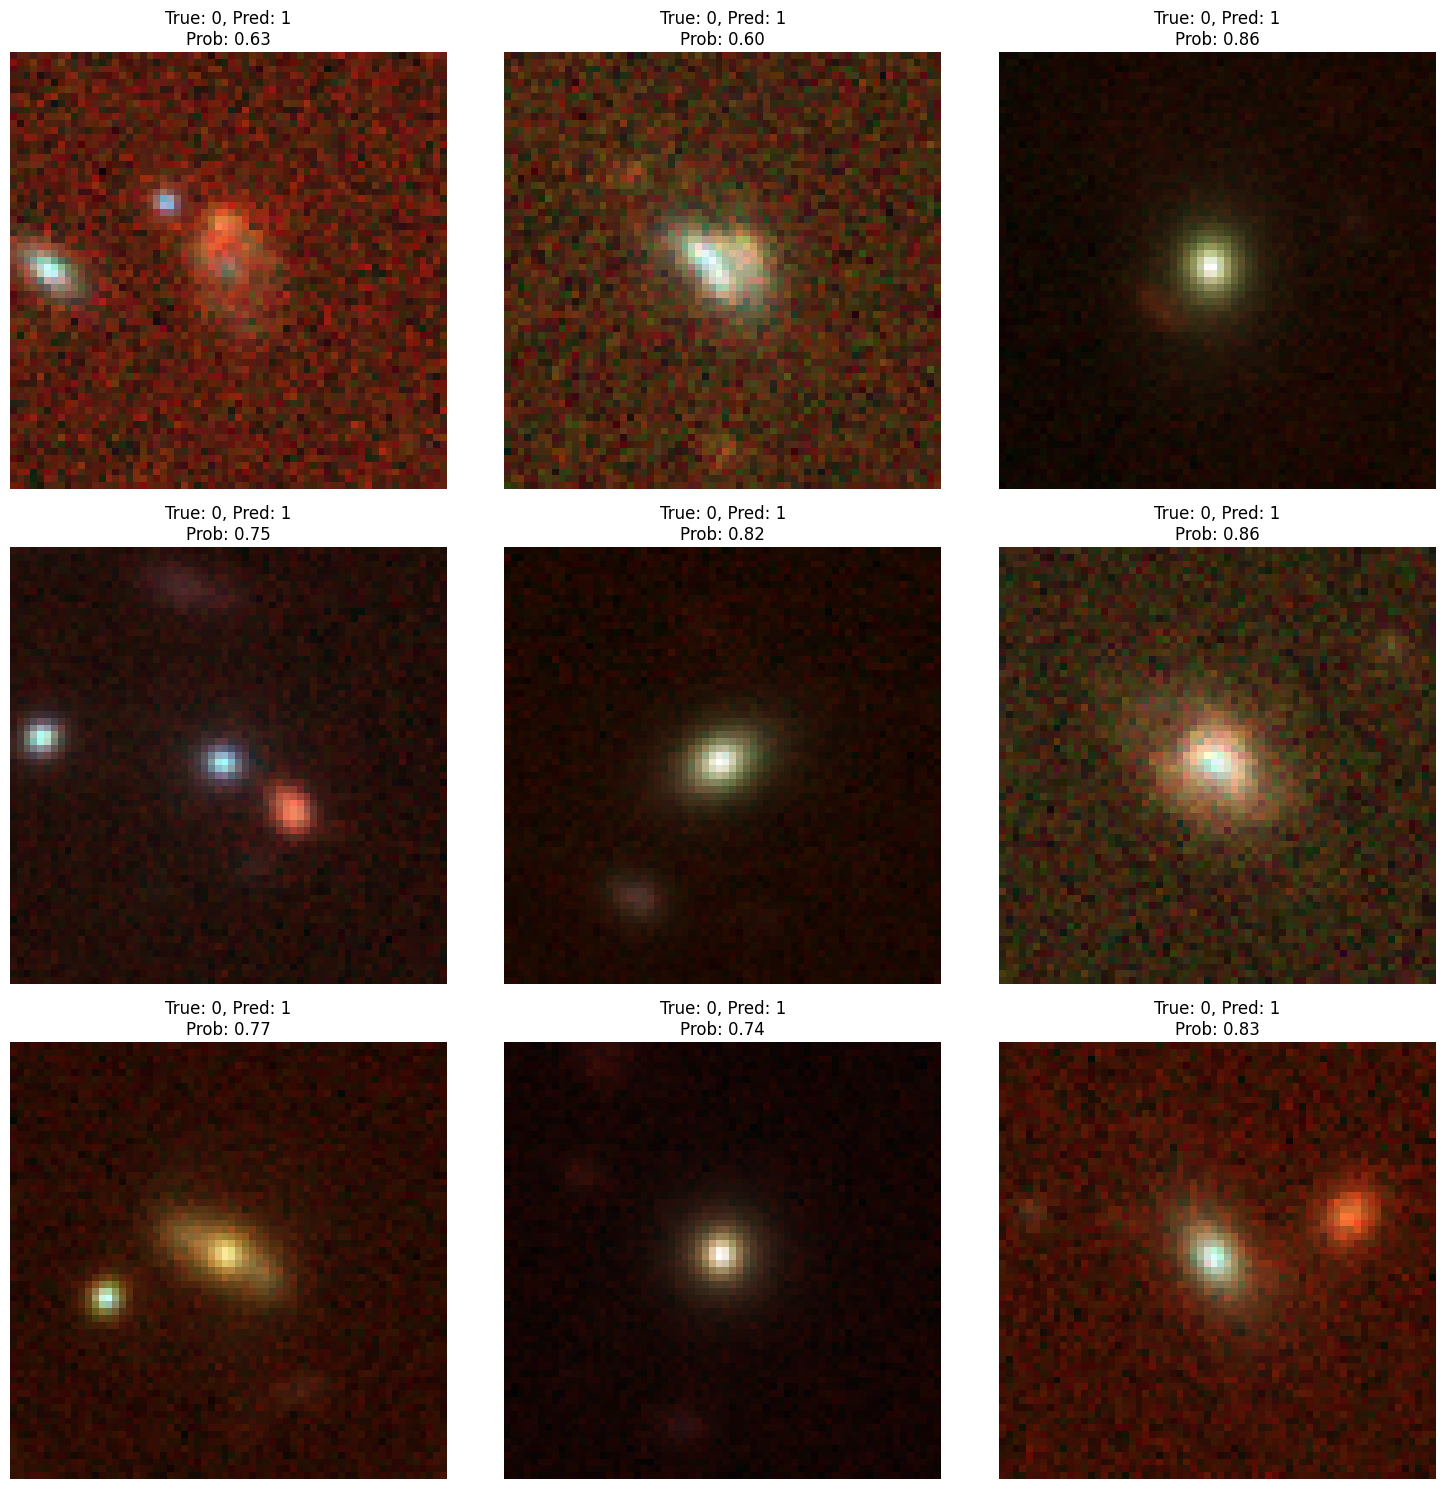

In [45]:
plt.figure(figsize=(15, 15))
for i, idx in enumerate(selected_indices):
    # Load image from file; images are stored in (3, 64, 64) so transpose to (64, 64, 3) for display
    image = np.load(test_files[idx])
    image_to_show = np.transpose(image, (1, 2, 0))
    
    true_label = true_labels[idx]
    pred_prob = predicted_probs[idx]
    pred_label = 1 if pred_prob >= 0.5 else 0
    
    plt.subplot(3, 3, i+1)
    plt.imshow(image_to_show, cmap='gray')
    plt.title(f"True: {true_label}, Pred: {pred_label}\nProb: {pred_prob:.2f}")
    plt.axis('off')

plt.tight_layout()
plt.show()

## Conclusion & Future Work

The CNN achieved a high AUC score (e.g., ~0.9877 on validation and ~0.9648 on the test set), indicating good performance in identifying strong gravitational lenses.

**Future Work:**
- Further hyperparameter tuning and data augmentation.
- Experimentation with more advanced architectures (e.g., ResNet).